In [1]:
import pandas as pd
import numpy as np
import time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_parquet("../data/final_merged_dataset.parquet")
df['year'] = df.index.year
df = df[df['year'].isin([2021, 2022, 2023, 2024])]


In [3]:
def replace_inf(X):
	return X.replace([np.inf, -np.inf], np.nan).fillna(0)
df = replace_inf(df)

In [4]:
df

,news_count,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,source_AMBCrypto,source_BeInCrypto,source_Benzinga,...,upper_band_20,middle_band_20,lower_band_20,10_band_width,pct_b_10,20_band_width,pct_b_20,reddit_total_sentiment,reddit_average_sentiment,year
2021-01-01 06:00:00,2.0,0.850000,0.000000,0.000000,0.000000,0.150000,0.0,0.0,0.0,0.0,...,29450.949582,28913.7180,28376.486418,0.039453,0.942558,0.037161,1.026218,-0.8910,-0.111375,2021
2021-01-01 07:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,29488.063359,28931.4545,28374.845641,0.030480,0.715670,0.038478,0.785547,0.0000,0.000000,2021
2021-01-01 08:00:00,2.0,0.400000,0.000000,0.000000,0.000000,0.500000,0.0,0.0,1.0,0.0,...,29515.716093,28939.8210,28363.925907,0.024058,0.803534,0.039799,0.852329,0.0000,0.000000,2021
2021-01-01 09:00:00,2.0,-0.050000,0.000000,0.000000,0.000000,0.400000,0.0,0.0,0.0,0.0,...,29553.465096,28957.6910,28361.916904,0.022668,0.682311,0.041148,0.779207,0.0000,0.000000,2021
2021-01-01 10:00:00,3.0,0.766667,0.000000,0.000000,0.000000,0.300000,0.0,1.0,0.0,0.0,...,29578.630359,28970.1450,28361.659641,0.020372,0.572225,0.042008,0.723469,0.0000,0.000000,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,7.0,0.342857,0.157143,0.114286,0.014286,0.471429,0.0,0.0,0.0,0.0,...,95433.425204,94002.9000,92572.374796,0.027178,0.301965,0.030436,0.501783,0.0000,0.000000,2024
2024-12-31 20:00:00,6.0,0.216667,0.016667,0.083333,0.000000,0.483333,0.0,0.0,0.0,0.0,...,95435.711991,93998.4000,92561.088009,0.029955,0.130123,0.030582,0.297052,0.0000,0.000000,2024
2024-12-31 21:00:00,3.0,0.100000,0.233333,0.200000,0.000000,0.300000,0.0,0.0,1.0,0.0,...,95434.444994,94007.2500,92580.055006,0.031291,0.249877,0.030364,0.386053,0.0000,0.000000,2024
2024-12-31 22:00:00,4.0,0.200000,0.200000,0.475000,0.000000,0.925000,0.0,1.0,0.0,0.0,...,95441.599457,93996.7000,92551.800543,0.034452,0.187972,0.030744,0.256834,0.6312,0.028691,2024


### Remove non-stationarity column features

In [5]:
columns = df.columns.tolist()
for i in range(0, len(columns), 5):
  print(columns[i:i+5])

['news_count', 'tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa']
['adoption_absa', 'cybersecurity_absa', 'source_AMBCrypto', 'source_BeInCrypto', 'source_Benzinga']
['source_Bitcoin', 'source_Bitcoin Magazine', 'source_CoinPedia', 'source_Coindesk', 'source_Coingape']
['source_Cointelegraph', 'source_CryptoPotato', 'source_Cryptopolitan', 'source_NewsBTC', 'source_Other']
['source_The Currency Analytics', 'source_The Daily Hodl', 'source_UToday', 'topic_Other', 'topic_exchange traded funds, ETF']
['topic_institutional investments', 'topic_market sentiment', 'topic_others', 'topic_price action, price movement, trading', 'NER_binance']
['NER_blackrock', 'NER_coinbase', 'NER_el salvador', 'NER_fed', 'NER_grayscale']
['NER_michael saylor', 'NER_microstrategy', 'NER_sec', 'NER_us', 'return_forward']
['open', 'high', 'low', 'close', 'volume']
['return', 'sma_5', 'sma_20', 'sma_50', 'sma_200']
['ema_5', 'ema_20', 'ema_50', 'ema_200', 'sma_5_20_diff']
['sma_20_50_diff', '

In [6]:
df.drop(columns=[
  'open', 'high', 'low', 'close', 'volume', 'return', 
  'sma_5', 'sma_20', 'sma_50', 'sma_200', 
  'ema_5', 'ema_20', 'ema_50', 'ema_200'
], inplace=True)

### Create 3-class prediction target

In [7]:
# Create 3-class target:
df['target'] = np.where(df['return_forward'] > 0.001, 2,
                        np.where(df['return_forward'] < -0.001, 0, 1))

print("Target class distribution:")
print(df['target'].value_counts())

Target class distribution:
target
2    13105
0    12641
1     9312
Name: count, dtype: int64


### Feature enginnering on news related columns

In [8]:
absa_cols = ['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa', 'cybersecurity_absa']
for col in absa_cols:
  df[col + '_ewm_12h'] = df[col].ewm(span=12, adjust=False).mean()
  df[col + '_ewm_70h'] = df[col].ewm(span=70, adjust=False).mean()
df.drop(columns=absa_cols, inplace=True)
df.head()

,news_count,source_AMBCrypto,source_BeInCrypto,source_Benzinga,source_Bitcoin,source_Bitcoin Magazine,source_CoinPedia,source_Coindesk,source_Coingape,source_Cointelegraph,...,economy_absa_ewm_12h,economy_absa_ewm_70h,regulation_absa_ewm_12h,regulation_absa_ewm_70h,technology_absa_ewm_12h,technology_absa_ewm_70h,adoption_absa_ewm_12h,adoption_absa_ewm_70h,cybersecurity_absa_ewm_12h,cybersecurity_absa_ewm_70h
2021-01-01 06:00:00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.150000,0.150000,0.0,0.0
2021-01-01 07:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.126923,0.145775,0.0,0.0
2021-01-01 08:00:00,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.184320,0.155753,0.0,0.0
2021-01-01 09:00:00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.217501,0.162633,0.0,0.0
2021-01-01 10:00:00,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.230193,0.166503,0.0,0.0


In [9]:
columns_to_engineer = [
  'source_AMBCrypto', 'source_BeInCrypto', 'source_Benzinga',
  'source_Bitcoin', 'source_Bitcoin Magazine', 'source_CoinPedia', 'source_Coindesk', 'source_Coingape',
  'source_Cointelegraph', 'source_CryptoPotato', 'source_Cryptopolitan', 'source_NewsBTC', 'source_Other',
  'source_The Currency Analytics', 'source_The Daily Hodl', 'source_UToday',
  'topic_Other', 'topic_exchange traded funds, ETF',
  'topic_institutional investments', 'topic_market sentiment', 'topic_others', 'topic_price action, price movement, trading', 'NER_binance',
  'NER_blackrock', 'NER_coinbase', 'NER_el salvador', 'NER_fed', 'NER_grayscale',
  'NER_michael saylor', 'NER_microstrategy', 'NER_sec', 'NER_us'
]

# # If any row in the window has a 1 then the maximum will be 1, else 0.
for col in columns_to_engineer:
  df[col + "_last3"] = df[col].rolling(window=5, min_periods=1).max().astype(int)
  df[col + "_last24"] = df[col].rolling(window=48, min_periods=1).max().astype(int)

df.drop(columns=columns_to_engineer, inplace=True)
df.head()

,news_count,return_forward,sma_5_20_diff,sma_20_50_diff,sma_50_200_diff,ema_5_20_diff,ema_20_50_diff,ema_50_200_diff,sma_5_20_diff_abs_chg,sma_5_20_diff_pct_chg,...,NER_grayscale_last3,NER_grayscale_last24,NER_michael saylor_last3,NER_michael saylor_last24,NER_microstrategy_last3,NER_microstrategy_last24,NER_sec_last3,NER_sec_last24,NER_us_last3,NER_us_last24
2021-01-01 06:00:00,2.0,-0.007795,219.4000,351.4194,2328.15940,253.706224,434.108627,1931.153143,30.9855,0.164454,...,1,1,0,0,0,0,0,0,0,0
2021-01-01 07:00:00,0.0,0.003292,253.0935,336.2693,2332.87565,247.173223,435.446110,1934.233818,33.6935,0.153571,...,1,1,0,0,0,0,0,0,0,0
2021-01-01 08:00:00,2.0,-0.001883,284.9410,309.6284,2338.85115,258.314486,440.377401,1939.227744,31.8475,0.125833,...,1,1,1,1,1,1,0,0,0,0
2021-01-01 09:00:00,2.0,-0.001648,326.5890,301.5680,2335.72595,243.679390,439.924107,1941.604473,41.6480,0.146164,...,1,1,1,1,1,1,0,0,0,0
2021-01-01 10:00:00,3.0,0.000118,351.1670,289.6874,2330.35155,215.620781,435.182264,1941.694715,24.5780,0.075257,...,1,1,1,1,1,1,0,0,0,0


In [10]:
source_cols = [
  'source_Benzinga_last3', 'source_Benzinga_last24', 'source_Bitcoin_last3', 'source_Bitcoin_last24', 'source_Bitcoin Magazine_last3',
  'source_Bitcoin Magazine_last24', 'source_CoinPedia_last3', 'source_CoinPedia_last24', 'source_Coindesk_last3', 'source_Coindesk_last24',
  'source_Coingape_last3', 'source_Coingape_last24', 'source_Cointelegraph_last3', 'source_Cointelegraph_last24', 'source_CryptoPotato_last3',
  'source_CryptoPotato_last24', 'source_Cryptopolitan_last3', 'source_Cryptopolitan_last24', 'source_NewsBTC_last3', 'source_NewsBTC_last24',
  'source_Other_last3', 'source_Other_last24', 'source_The Currency Analytics_last3', 'source_The Currency Analytics_last24', 'source_The Daily Hodl_last3',
  'source_The Daily Hodl_last24', 'source_UToday_last3', 'source_UToday_last24'
]

# if value > 0, then 1 else 0
for col in source_cols:
  df[col] = df[col].apply(lambda x: 1 if x > 0 else 0)

In [11]:
# remove unwanted cols
col_to_remove = [
  'cybersecurity_absa_ewm_12h', 'cybersecurity_absa_ewm_70h',
  'NER_us_last24', 'topic_others_last24', 'topic_price action, price movement, trading_last24', 'topic_Other_last24'
]
df.drop(columns=col_to_remove, inplace=True)

### Feature engineering on reddit

In [12]:
reddit_col = ['reddit_total_sentiment', 'reddit_average_sentiment']

# apply ewm to reddit columns
for col in reddit_col:
  df[col + '_ewm_5h'] = df[col].ewm(span=5, adjust=False).mean()
  df[col + '_ewm_24h'] = df[col].ewm(span=24, adjust=False).mean()

df.drop(columns=reddit_col, inplace=True)

### Save dataset with feature engineering

In [13]:
df.to_parquet("../data/full_dataset_feature_engineering_v1.parquet", index=True)

In [14]:
df

,news_count,return_forward,sma_5_20_diff,sma_20_50_diff,sma_50_200_diff,ema_5_20_diff,ema_20_50_diff,ema_50_200_diff,sma_5_20_diff_abs_chg,sma_5_20_diff_pct_chg,...,NER_michael saylor_last24,NER_microstrategy_last3,NER_microstrategy_last24,NER_sec_last3,NER_sec_last24,NER_us_last3,reddit_total_sentiment_ewm_5h,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h
2021-01-01 06:00:00,2.0,-0.007795,219.4000,351.4194,2328.15940,253.706224,434.108627,1931.153143,30.9855,0.164454,...,0,0,0,0,0,0,-0.891000,-0.891000,-0.111375,-0.111375
2021-01-01 07:00:00,0.0,0.003292,253.0935,336.2693,2332.87565,247.173223,435.446110,1934.233818,33.6935,0.153571,...,0,0,0,0,0,0,-0.594000,-0.819720,-0.074250,-0.102465
2021-01-01 08:00:00,2.0,-0.001883,284.9410,309.6284,2338.85115,258.314486,440.377401,1939.227744,31.8475,0.125833,...,1,1,1,0,0,0,-0.396000,-0.754142,-0.049500,-0.094268
2021-01-01 09:00:00,2.0,-0.001648,326.5890,301.5680,2335.72595,243.679390,439.924107,1941.604473,41.6480,0.146164,...,1,1,1,0,0,0,-0.264000,-0.693811,-0.033000,-0.086726
2021-01-01 10:00:00,3.0,0.000118,351.1670,289.6874,2330.35155,215.620781,435.182264,1941.694715,24.5780,0.075257,...,1,1,1,0,0,0,-0.176000,-0.638306,-0.022000,-0.079788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,7.0,-0.006308,339.3000,312.8600,-1716.76500,92.250077,114.783572,-1486.632740,-329.9500,-0.493015,...,1,1,1,1,1,1,0.369066,0.208662,0.026292,0.015598
2024-12-31 20:00:00,6.0,0.002858,-30.2000,309.9000,-1704.44000,-105.563575,70.973167,-1489.015782,-369.5000,-1.089007,...,1,0,1,1,1,1,0.246044,0.191969,0.017528,0.014350
2024-12-31 21:00:00,3.0,-0.004142,-238.4500,313.7300,-1694.03500,-157.957093,47.582523,-1482.887694,-208.2500,6.895695,...,1,0,1,1,1,1,0.164029,0.176611,0.011685,0.013202
2024-12-31 22:00:00,4.0,0.000933,-365.3000,310.7600,-1696.71500,-276.925974,5.335072,-1487.834867,-126.8500,0.531977,...,1,0,1,0,1,1,0.319753,0.212978,0.017354,0.014441


### Feature scaling

### Spliting dataset

In [15]:
# list of features column names
all_features = df.columns.drop(['target', 'return_forward'])

In [16]:
df_train = df[df['year'].isin([2021, 2022, 2023])]
df_test = df[df['year'] == 2024]

X_train = df_train[all_features]
y_train = df_train['target']
X_test = df_test[all_features]
y_test = df_test['target']

# Print class distribution
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

Training set class distribution: [ 9993  6038 10243]
Test set class distribution: [2648 3274 2862]


### Logistic regression

In [ ]:
# Time Series Cross-Validation for RFECV and potential outer loop if needed
tscv = TimeSeriesSplit(n_splits=5)

# Define the base Logistic Regression model
lr_model = LogisticRegression(
    penalty='l1',         # L1 regularization
    solver='saga',       # Optimizer for L1
    max_iter=5000,       # Ensure convergence
    random_state=42,
    class_weight='balanced', # Handle class imbalance
    C=1.0                # Default C, or could be tuned
)

# Setup RFECV
rfecv = RFECV(
    estimator=lr_model,
    step=1,                # Remove one feature at a time
    cv=tscv,               # Use time series cross-validation
    scoring='roc_auc_ovr', # Scoring metric for multi-class
    min_features_to_select=10, # Minimum number of features
    n_jobs=-1,
    verbose=1
)

# Create the pipeline with scaling and RFECV
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', rfecv)
    # The final estimator (lr_model) is part of RFECV
])

# Fit the pipeline (which includes RFECV)
# No GridSearchCV needed here unless tuning RFECV parameters
print("Starting RFECV fitting...")
pipeline.fit(X_train, y_train)
print("RFECV fitting complete.")

# The best estimator is now the fitted pipeline itself
best_model = pipeline

# RFECV automatically refits the estimator on the full training data with the selected features
print(f"Optimal number of features selected by RFECV: {best_model.named_steps['feature_selection'].n_features_}")

Starting RFECV fitting...


In [ ]:
# Evaluate on test set using the fitted pipeline
y_pred = best_model.predict(X_test)
y_proba_full = best_model.predict_proba(X_test)

In [ ]:
# Performance metrics
# print(f"Best Parameters: {grid_search.best_params_}") # No grid search used
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Get the full probability matrix for multi-class ROC AUC
# y_proba_full = best_model.predict_proba(X_test) # Already calculated
print(f"Test ROC AUC (OvR): {roc_auc_score(y_test, y_proba_full, multi_class='ovr'):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'model__C': 0.1}

Test Accuracy: 0.4714
Test ROC AUC: 0.7041

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.29      0.34      2648
           1       0.49      0.81      0.62      3274
           2       0.47      0.25      0.33      2862

    accuracy                           0.47      8784
   macro avg       0.46      0.45      0.43      8784
weighted avg       0.46      0.47      0.44      8784



Shape of coefficient matrix: (3, 139)

Top 15 most important features for Bearish (0):
                            Feature  Coefficient  Abs_Coefficient
32                            rsi_7     0.146943         0.146943
25                              +di    -0.118648         0.118648
13            ema_5_20_diff_abs_chg    -0.097328         0.097328
61                         pct_b_10     0.083374         0.083374
48             norm_price_change_14     0.054972         0.054972
1                     sma_5_20_diff    -0.053879         0.053879
130         NER_microstrategy_last3    -0.049454         0.049454
66           tanalysis_absa_ewm_70h    -0.039651         0.039651
59                    lower_band_20     0.034390         0.034390
136  reddit_total_sentiment_ewm_24h    -0.033936         0.033936
124                   NER_fed_last3     0.029538         0.029538
114              topic_others_last3    -0.028875         0.028875
116               NER_binance_last3     0.026338       

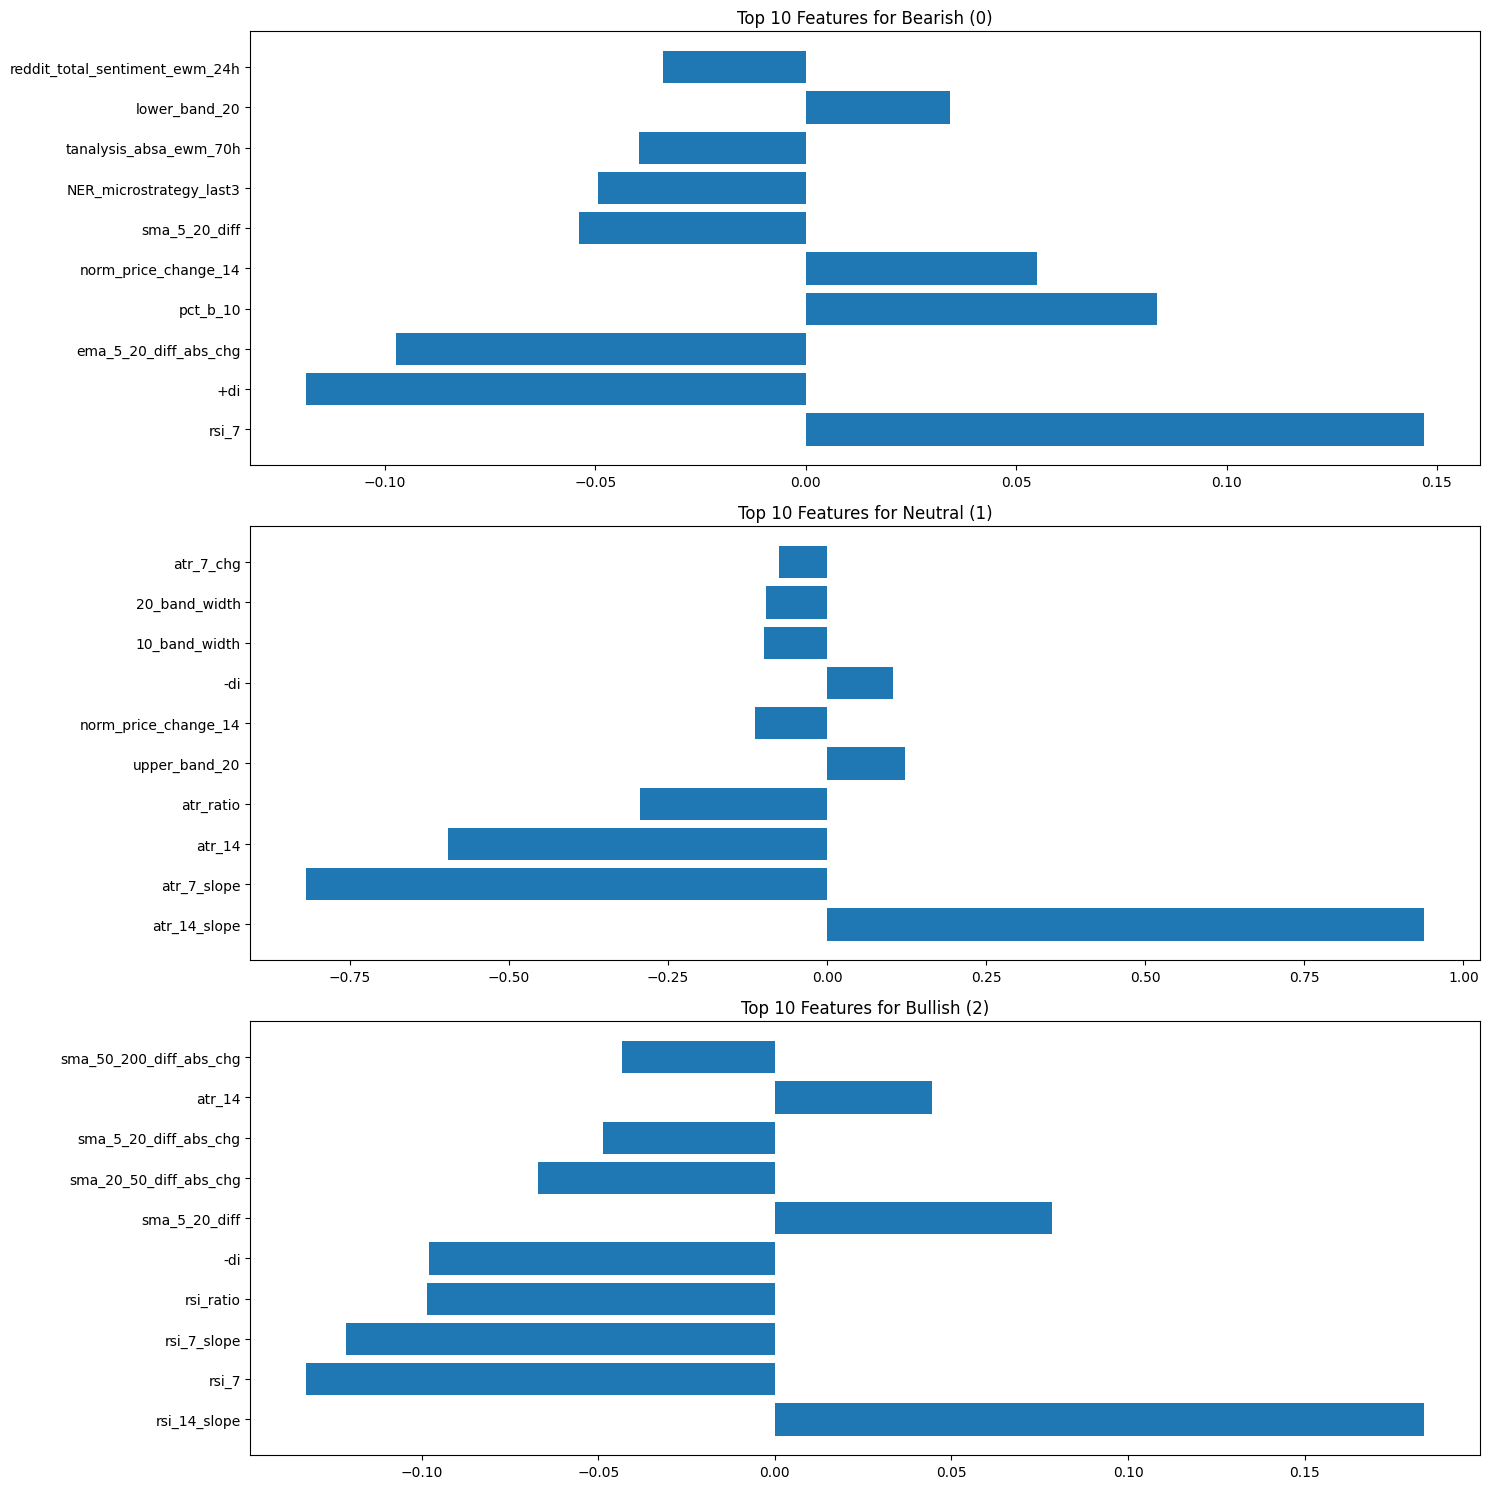


Number of features used by the model (non-zero coefficients): 220
Total number of features: 417
Feature utilization: 52.76%


In [ ]:
# Get the final fitted Logistic Regression model from RFECV
final_estimator = best_model.named_steps['feature_selection'].estimator_
coefficients = final_estimator.coef_

# Get the boolean mask of selected features from RFECV
feature_mask = best_model.named_steps['feature_selection'].support_

# Get the names of the selected features
all_feature_names = X_train.columns
selected_feature_names = all_feature_names[feature_mask]

# Print the shape of coefficients to understand the structure
print(f"Shape of coefficient matrix (selected features): {coefficients.shape}")
print(f"Number of selected features: {len(selected_feature_names)}")

# Create a function to display coefficients for a class
def display_class_coefficients(class_idx, class_name):
  # For multi-class, coefficients has shape (n_classes, n_selected_features)
  class_coefs = coefficients[class_idx]
  
  # Create a DataFrame using selected feature names
  coef_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Coefficient': class_coefs
  })
  
  # Sort by absolute coefficient value
  coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
  coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
  
  # Display top features
  print(f"\nTop 15 most important features for {class_name} (among selected):")
  print(coef_df.head(15))
  
  return coef_df

# Display coefficients for each class
class_names = ['Bearish (0)', 'Neutral (1)', 'Bullish (2)']

plt.figure(figsize=(15, 15))

for i, class_name in enumerate(class_names):
  coef_df = display_class_coefficients(i, class_name)
  
  # Plot top 10
  top_10_df = coef_df.head(10)
  plt.subplot(3, 1, i+1)
  plt.barh(top_10_df['Feature'], top_10_df['Coefficient'])
  plt.title(f'Top 10 Features for {class_name} (among selected)')
  plt.gca().invert_yaxis() # Display most important at top

plt.tight_layout()
plt.show()

# Count number of non-zero coefficients (already selected by RFECV, L1 might zero out more)
non_zero_coef = (np.abs(coefficients) > 1e-5).sum()
print(f"\nNumber of features selected by RFECV: {len(selected_feature_names)}")
print(f"Number of non-zero coefficients after L1 (within selected): {non_zero_coef}")
print(f"Total number of original features: {len(all_feature_names)}")

In [ ]:
# Add predictions and probabilities to test dataframe
df_test_copy = df_test.copy() # Avoid SettingWithCopyWarning
df_test_copy.loc[:, 'predicted_class'] = y_pred
df_test_copy.loc[:, 'prob_bearish'] = y_proba_full[:, 0]
df_test_copy.loc[:, 'prob_neutral'] = y_proba_full[:, 1]
df_test_copy.loc[:, 'prob_bullish'] = y_proba_full[:, 2]

# Map target values to more descriptive labels
target_map = {0: 'Bearish', 1: 'Neutral', 2: 'Bullish'}
df_test_copy.loc[:, 'actual_label'] = df_test_copy['target'].map(target_map)
df_test_copy.loc[:, 'predicted_label'] = df_test_copy['predicted_class'].map(target_map)

# Calculate whether the prediction was correct
df_test_copy.loc[:, 'correct_prediction'] = (df_test_copy['target'] == df_test_copy['predicted_class']).astype(int)

# Calculate monthly accuracy
monthly_accuracy = df_test_copy.resample('ME')['correct_prediction'].mean()

# Plot monthly accuracy
plt.figure(figsize=(12, 6))
monthly_accuracy.plot(kind='bar')
plt.title('Model Prediction Accuracy by Month (2024)')
plt.ylabel('Accuracy')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show confusion matrix
conf_matrix = confusion_matrix(df_test_copy['target'], df_test_copy['predicted_class'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
      xticklabels=['Bearish', 'Neutral', 'Bullish'],
      yticklabels=['Bearish', 'Neutral', 'Bullish'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Assign back if needed, or use df_test_copy going forward
df_test = df_test_copy

### Backtest

In [ ]:
df_test.head()

,news_count,return_forward,sma_5_20_diff,sma_20_50_diff,sma_50_200_diff,ema_5_20_diff,ema_20_50_diff,ema_50_200_diff,sma_5_20_diff_abs_chg,sma_5_20_diff_pct_chg,...,reddit_total_sentiment_ewm_24h,reddit_average_sentiment_ewm_5h,reddit_average_sentiment_ewm_24h,predicted_class,prob_bearish,prob_neutral,prob_bullish,actual_label,predicted_label,correct_prediction
2024-01-01 00:00:00,0.0,-0.001385,143.55,210.51,-647.125,123.182375,73.241757,-290.164294,-3.40,-0.023137,...,0.097778,0.003539,0.010173,1,0.195755,0.615062,0.189182,Bearish,Neutral,0
2024-01-01 01:00:00,1.0,-0.000729,151.35,210.81,-631.665,101.159360,74.849008,-282.793610,7.80,0.054336,...,0.089956,0.002359,0.009359,1,0.255325,0.541400,0.203275,Neutral,Neutral,1
2024-01-01 02:00:00,3.0,-0.005929,120.60,219.66,-617.505,77.283277,74.229918,-276.579317,-30.75,-0.203171,...,0.135111,0.028840,0.015154,1,0.277722,0.476475,0.245802,Bearish,Neutral,0
2024-01-01 03:00:00,4.0,0.000095,43.45,223.39,-605.320,0.428392,59.296872,-277.935098,-77.15,-0.639718,...,0.124302,0.019226,0.013942,2,0.230066,0.361258,0.408676,Neutral,Bullish,0
2024-01-01 04:00:00,2.0,0.005017,-37.10,221.12,-591.100,-44.989742,46.318484,-278.999237,-80.55,-1.853855,...,0.114358,0.012818,0.012827,1,0.229782,0.392929,0.377289,Bullish,Neutral,0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
from decimal import Decimal
warnings.filterwarnings("ignore")

# df must have index as datetime64[ns], and 'signal' column
# freq can be 'd', 'h', '5min', or '15min'
def run_backtest(df, freq='d'):

  # check if df.index is datetime64[ns]
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  # ------------------ Return Data Preparation ------------------
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'd':
    df = concat_return(df, freq)
    period_in_a_year = 365
  elif freq == 'h':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24
  elif freq == '5min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 12
  elif freq == '15min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 4
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  # ------------------ Data check ------------------
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  # ------------------ Return & Sharpe ------------------
  # Daily returns
  df['strategy_return'] = df['signal'] * df['return_forward']

  # Geometric Annual Return
  num_periods = len(df)
  annual_return_geometric = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  
  # Arithmetic Annual Return for sharpe ratio calculation
  annual_return_arithmetic = df['strategy_return'].mean() * period_in_a_year

  # Sharpe Ratio
  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return_arithmetic / annual_std

  print(f"Overall Annual Return: {round(annual_return_geometric*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  # ------------------ Maximum Drawdown ------------------
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  # ------------------ Win/Loss Ratio ------------------
  # winning_trades = (df['strategy_return'] > 0).sum()
  # losing_trades = (df['strategy_return'] < 0).sum()
  # if losing_trades > 0:
  #   win_loss_ratio = winning_trades / losing_trades
  # else:
  #   win_loss_ratio = np.nan # no losing trades (advoid division by zero)
  # print("Win/Loss Ratio:", round(win_loss_ratio, 4))

  # ------------------ Alpha and Beta ------------------
  # Beta = Cov(strategy_return, acutal_return) / Var(actual_return)
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  # Alpha = mean(strategy_return) - Beta * mean(actual_return)
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  # Annualize alpha
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  # ------------------- Yearly Metrics -------------------
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return_arithmetic': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return_arithmetic'] / yearly_data['yearly_std']
  yearly_data.drop(columns=['yearly_return_arithmetic'], inplace=True)
  print("\nYearly Metrics:")
  print(yearly_data)

  # ------------------------- Plots ----------------------
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  # cumulative return plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

  # Signal weight plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.show()


def concat_return(df, freq='d'):
  if freq == 'd':
    file_path = "../../bitcoin_historical_price/btcusd_daily_price.parquet"
  elif freq == 'h':
    file_path = "../../bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == '5min':
    file_path = "../../bitcoin_historical_price/btcusd_5min_price.parquet"
  elif freq == '15min':
    file_path = "../../bitcoin_historical_price/btcusd_15min_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  # merge return_forward to df
  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')

  # turn return_forward from decimal to float
  merged_df['return_forward'] = merged_df['return_forward'].apply(lambda x: float(x))
  return merged_df

Overall Annual Return: -12.37%
Overall Annual Sharpe Ratio: -0.1141
Maximum Drawdown: -42.7 %
Alpha: -0.0899
Beta: 0.0506

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024      -0.123728     0.41208     0.050649     -0.094159      -0.114082


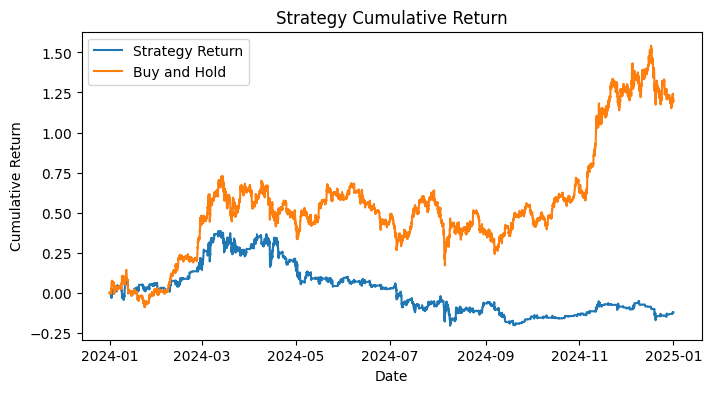

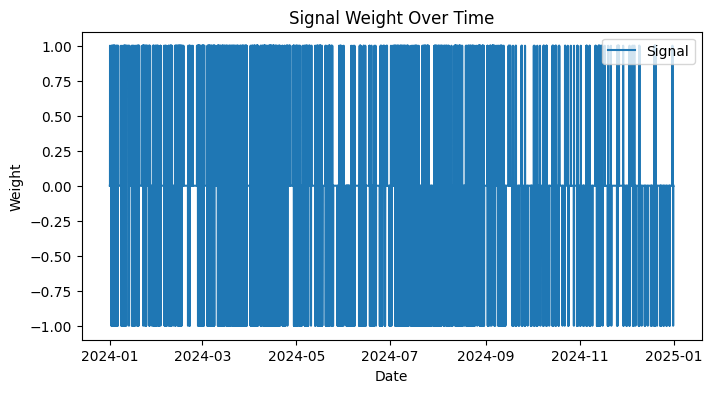

In [ ]:
# Ensure df_test has the necessary columns after modifications
if 'predicted_class' not in df_test.columns:
    print("Error: 'predicted_class' column missing in df_test before backtest.")
    # Potentially re-run the prediction cell or handle error
else:
    df_test['signal'] = df_test['predicted_class'] - 1
    print("Running backtest...")
    run_backtest(df_test, freq='h')